In [1]:
#hide
#skip
%config Completer.use_jedi = False
%config IPCompleter.greedy=True
# upgrade fastrl on colab
! [ -e /content ] && pip install -Uqq fastrl['dev'] pyvirtualdisplay && \
                     apt-get install -y xvfb python-opengl > /dev/null 2>&1 
# NOTE: IF YOU SEE VERSION ERRORS, IT IS SAFE TO IGNORE THEM. COLAB IS BEHIND IN SOME OF THE PACKAGE VERSIONS

In [2]:
# hide
from fastcore.imports import in_colab
# Since colab still requires tornado<6, we don't want to import nbdev if we don't have to
if not in_colab():
    from nbdev.showdoc import *
    from nbdev.imports import *
    if not os.environ.get("IN_TEST", None):
        assert IN_NOTEBOOK
        assert not IN_COLAB
        assert IN_IPYTHON
else:
    # Virutual display is needed for colab
    from pyvirtualdisplay import Display
    display = Display(visible=0, size=(400, 300))
    display.start()

In [3]:
# default_exp fastai.learner

In [1]:
# export
# Python native modules
import os
from typing import *
# Third party libs
from fastcore.all import *
from torch.utils.data.dataloader_experimental import DataLoader2
import torchdata.datapipes as dp
from torch.nn import *
from torch.optim import *
from fastai.torch_basics import *
from fastai.torch_core import *
from torch.utils.data.graph import traverse

# Local modules
from fastrl.fastai.data.block import *
from fastrl.fastai.data.pipes.core import *

In [2]:
master_bar??

Init signature:
master_bar(
    gen,
    total=None,
    hide_graph=False,
    order=None,
    clean_on_interrupt=False,
    total_time=False,
)
Docstring:      <no docstring>
Source:        
class NBMasterBar(MasterBar):
    names = ['train', 'valid']
    def __init__(self, gen, total=None, hide_graph=False, order=None, clean_on_interrupt=False, total_time=False):
        super().__init__(gen, NBProgressBar, total)
        if order is None: order = ['pb1', 'text', 'pb2']
        self.hide_graph,self.order = hide_graph,order
        self.report,self.clean_on_interrupt,self.total_time = [],clean_on_interrupt,total_time
        self.inner_dict = {'pb1':self.main_bar, 'text':""}
        self.text,self.lines = "",[]

    def on_iter_begin(self):
        self.html_code = '\n'.join([html_progress_bar(0, self.main_bar.total, ""), ""])
        display(HTML(html_progress_bar_styles))
        self.out = display(HTML(self.html_code), display_id=True)

    def on_interrupt(self):
        if self.c

# Learner
> A revised fastai learner that uses DataPipe shimming

In [5]:
# export
class XYSplit(dp.iter.IterDataPipe):
    def __init__(self,source_datapipe,learn,x_fld):
        self.source_datapipe = source_datapipe
        self.learn = learn
        self.x_fld = x_fld
        
    def __iter__(self):
        for b in self.source_datapipe:
            
            for v in b.values():
                if v.shape[0]==1 and len(v.shape)!=2: v.squeeze_(0)

            yield (b[self.x_fld],b)

In [6]:
# export
class ModelPredict(dp.iter.IterDataPipe):
    def __init__(self,source_datapipe,learn):
        self.source_datapipe = source_datapipe
        self.learn = learn
        
    def __iter__(self):
        for xb,yb in self.source_datapipe:
            self.learn.xb = xb
            self.learn.yb = yb
            self.learn.preds = self.learn.model(xb)
            yield self.learn.preds

In [7]:
# export
class LossCalc(dp.iter.IterDataPipe):
    def __init__(self,source_datapipe,learn,y_target=None):
        self.source_datapipe = source_datapipe
        self.learn = learn
        self.y_target = y_target
        
    def __iter__(self):
        for batch in self.source_datapipe:
            if self.y_target is None:
                self.learn.loss_grad = self.learn.loss_func(self.learn.preds, *self.learn.yb)
            else:
                self.loss_grad = self.learn.loss_func(self.learn.preds, *self.learn.yb[self.y_target])
            self.learn.loss = self.learn.loss_grad.clone()
            yield self.learn.loss

In [8]:
# export
def default_train_loop(
    dls:List[DataLoader2],
    cbs:Optional[List[Callback]]=None,
):
    train_valid = L(dls).map(dp.iter.IterableWrapper).add_cbs(cbs)
    
    return train_vals

In [9]:
# export
def find_pipes(
    pipe:Union[dp.map.MapDataPipe,dp.iter.IterDataPipe],
    fn,
    pipe_list=None
):
    pipe_list = ifnone(pipe_list,[]) 
    if issubclass(pipe.__class__,(dp.map.MapDataPipe,dp.iter.IterDataPipe)) and fn(pipe): pipe_list.append(pipe)
    for v in traverse(pipe,only_datapipe=True).values(): # We dont want to traverse non-dp objects.
        for k,_ in v.items():
            cbs = find_pipes(k,fn,pipe_list)
    return pipe_list

In [10]:
# export
T_co = TypeVar("T_co", covariant=True)

class Epocher(dp.iter.IterDataPipe):
    def __init__(self,source_datapipe,epochs,learner):
        self.source_datapipe = source_datapipe
        self.learner = learner
        self.learner.epochs = epochs
        self.learner.epoch = 0
        self.learner.mbar = master_bar(list(range(self.learner.epochs)))
        
        self.metrics = None
    
    def __iter__(self) -> Iterator[T_co]:
        self.metrics = find_pipes(self.source_datapipe,lambda o:getattr(o,'is_metric',False))
        print('found: ',self.metrics)
        self.learner.mbar.write([o.name for o in self.metrics], table=True)
        for i in self.learner.mbar:
            yield from self.source_datapipe
            self.learner.epoch = i
            logs = [o.value for o in self.metrics]
            self.learner.mbar.write([f'{l:.6f}' if isinstance(l, float) else str(l) for l in logs], table=True)
                

In [11]:
# export
def only_train_loop(
    dls:List[DataLoader2],
    epochs:int,
    learner,
    cbs:Optional[List[Callback]]=None,
):
    
    train = dp.iter.IterableWrapper(dls,deepcopy=False)
    train = Epocher(train,epochs,learner=learner)

    # for _pipe in reversed(find_pipes(train,lambda o:True)): train = _pipe.add_cbs_before(cbs)
    # for _pipe in reversed(find_pipes(train,lambda o:True)): train = _pipe.add_cbs_after(cbs)
    train = add_cbs_to_pipes(train,cbs)
    
    return train

In [12]:
# export
class Learner(): #(dp.iter.IterDataPipe):
    def __init__(self,model,dls,opt,loss_func,cbs,train_loop=None):
        store_attr('model,dls,opt,loss_func')
        self.cbs = L()
        self.add_cbs(cbs)
        self.train_loop = ifnone(train_loop,default_train_loop)
        
    def fit(self,epochs):
        self.it = iter(self.dls[0])
        self.train_pipe = only_train_loop(L(self.it),epochs,self,self.cbs) # Do not pass tuple, otherwise traverse will try to read the dl datapipes
        for res in self.train_pipe:pass
            # print(res)

    def add_cbs(self, cbs):
        L(cbs).map(self.add_cb)
        return self

    def remove_cbs(self, cbs):
        L(cbs).map(self.remove_cb)
        return self

    def add_cb(self, cb):
        if isinstance(cb, type): cb = cb()
        cb.learn = self
        # cb.init_pipes()
        setattr(self, cb.name, cb)
        self.cbs.append(cb)
        return self

In [13]:
# export
class DQN(Module):
    def __init__(self,state_sz:int,action_sz:int,hidden=512):
        self.layers=Sequential(
            Linear(state_sz,hidden),
            ReLU(),
            Linear(hidden,action_sz),
        )
    def forward(self,x): return self.layers(x)

In [14]:
# export
class QCalc(dp.iter.IterDataPipe):
    def __init__(self,source_datapipe,learn,discount,nsteps):
        self.source_datapipe = source_datapipe
        self.learn = learn
        self.discount = discount
        self.nsteps = nsteps
        
    def __iter__(self):
        for batch in self.source_datapipe:
            self.learn.done_mask = self.learn.yb['done'].reshape(-1,)
            self.learn.next_q = self.learn.model(self.learn.yb['next_state'])
            self.learn.next_q = self.learn.next_q.max(dim=1).values.reshape(-1,1)
            self.learn.next_q[self.learn.done_mask] = 0 #xb[done_mask]['reward']
            self.learn.targets = self.learn.yb['reward']+self.learn.next_q*(self.discount**self.nsteps)
            self.learn.pred = self.learn.model(self.learn.yb['state'])
            
            
            t_q=self.learn.pred.clone()
            t_q.scatter_(1,self.learn.yb['action'],self.learn.targets)
            # finalize the xb and yb
            self.learn.yb=(t_q,)
            yield batch
            
class ModelLearnCalc(dp.iter.IterDataPipe):
    def __init__(self,source_datapipe,learn):
        self.source_datapipe = source_datapipe
        self.learn = learn
        
    def __iter__(self):
        for batch in self.source_datapipe:
            self.learn.loss_grad.backward()
            self.learn.opt.step()
            self.learn.opt.zero_grad()
            yield self.learn.loss

In [15]:
class Dict2TensorBatch(dp.iter.IterDataPipe):
    def __init__(self,source_datapipe,learn):
        self.source_datapipe = source_datapipe
        self.learn = learn

    def __iter__(self):
        for batch in self.source_datapipe:
            if not isinstance(batch,dict): 
                raise TypeError(f'Batch should be a dict, not {type(batch)}')
            yield {k:tensor(v) for k,v in batch.items()}

In [16]:
class ExperienceReplay(dp.iter.IterDataPipe):
    debug=False
    def __init__(self,source_datapipe,learn,bs=1,maxsz=100):
        self.memory = {}
        self.source_datapipe = source_datapipe
        self.learn = learn
        if learn is not None:
            self.learn.experience_replay = self
        self.bs = bs
        self.maxsz = maxsz
        self._sz_tracker = 0
    
    def sample(self,bs=None):  
        idxs = np.random.choice(range(self._sz_tracker),size=(ifnone(bs,self.bs),),replace=False)
        return {k:v[idxs] for k,v in self.memory.items()}

    def __iter__(self):
        for i,b in enumerate(self.source_datapipe):
            # print(f'batch {i}, {b}')
            if self.debug: print('Experience Replay Adding: ',b)
            for v in b.values():
                if not isinstance(v,Tensor): continue
                if v.shape[0]==1 and len(v.shape)!=2: v.squeeze_(0)
            if isinstance(b,dict):   self.add(b)
            elif isinstance(b,(list,tuple)): 
                for element in b: self.add(element)
                
            if self._sz_tracker<self.bs: continue
            yield self.sample()

    def add(self,d:Dict): 
        d = {k:to_np(v) if isinstance(v,Tensor) else np.array(v) for k,v in d.items()}
        if len(self.memory)==0: 
            self.memory = d
            self._sz_tracker = 1
        elif self._sz_tracker>self.maxsz:
            for k,v in self.memory.items():
                self.memory[k] = np.vstack((v[1:],d[k]))
            self._sz_tracker+=1
        else:
            for k,v in self.memory.items():
                self.memory[k] = np.vstack((v,d[k]))
            self._sz_tracker+=1

In [17]:
class ReinforcementLearningSimpleCallback(Callback):
    
    def add_core_hooks(self,before=None,after=dp.iter.IterableWrapper,not_under=None) -> List[dp.iter.IterDataPipe]:
        return L(
            partial(ExperienceReplay,learn=self.learn,bs=64,maxsz=100000),
            partial(Dict2TensorBatch,learn=self.learn),
            partial(XYSplit,learn=self.learn,x_fld='state'),
            partial(ModelPredict,learn=self.learn),
            partial(QCalc,learn=self.learn,discount=0.99,nsteps=3),
            partial(LossCalc,learn=self.learn),
            partial(ModelLearnCalc,learn=self.learn),
            partial(AvgLossMetric,learner=self.learn)
        )

        

In [18]:
class AvgLossMetric(dp.iter.IterDataPipe):
    is_metric = True
    def __init__(self,source_datapipe,learner):
        self.source_datapipe,self.learner,self.loss = source_datapipe,learner,0
    
    def __iter__(self):
        self.reset()
        for v in self.source_datapipe:
            bs = find_bs(self.learner.yb)
            self.total += float(to_detach(self.learner.loss.mean()))*bs
            self.count += bs
            yield v
        
    def reset(self): self.total,self.count = 0.,0
    @property
    def value(self): return self.total/self.count if self.count != 0 else None

    @property
    def name(self): return "loss"

from collections import deque

class RollingRewardMetric(dp.iter.IterDataPipe):
    is_metric = True
    def __init__(self,source_datapipe,learner,nrewards=10):
        self.source_datapipe,self.learner,self.rewards,self.nrewards = source_datapipe,learner,[],nrewards
    
    def __iter__(self):
        self.reset()
        for v in self.source_datapipe:
            rewards = v[v['done'].reshape(-1,)]['sum_reward'].reshape(-1,).tolist()
            
            self.rewards.extend(rewards)
            if len(self.rewards)>self.nrewards:
                self.rewards = self.rewards[-self.nrewards:]
                print('after adjust',self.rewards)
            
            yield v
        
    def reset(self): pass
    @property
    def value(self): 
        return np.average(self.rewards)

    @property
    def name(self): return "rolling_reward"

class EpsilonMetric(dp.iter.IterDataPipe):
    is_metric = True
    def __init__(self,source_datapipe,learner,epsilon_cb):
        self.source_datapipe,self.learner,self.epsilon_cb = source_datapipe,learner,epsilon_cb
    
    def __iter__(self):
        self.reset()
        for v in self.source_datapipe:
            self.epsilon = self.epsilon_cb.epsilon
            yield v
        
    def reset(self): pass
    @property
    def value(self): return self.epsilon

    @property
    def name(self): return "epsilon"


class RewardCallback(Callback):
    
    def __init__(self,epsilon_cb): self.epsilon_cb = epsilon_cb

    def add_core_hooks(self,before=None,after=dp.iter.IterableWrapper,not_under=None) -> List[dp.iter.IterDataPipe]:
        return L(
            partial(RollingRewardMetric,learner=self.learn)
        )

In [19]:
pipe = dp.iter.IterableWrapper([dict(test=np.array([i])) for i in range(10)])
exp = ExperienceReplay(pipe,None)

In [20]:
class BatchRecorder(dp.iter.IterDataPipe):
    def __init__(self,source_datapipe,learner):
        self.source_datapipe = source_datapipe
        self.learner = learner
        
    def __iter__(self):
        self.learner.pbar = progress_bar(list(range(self.learner.n)),parent=self.learner.mbar,leave=False)
        for _,o in zip(self.learner.pbar,self.source_datapipe):
            yield o
        
class RecorderCallback(Callback):
    
    def add_core_hooks(self,before=None,after=dp.iter.IterableWrapper,not_under=None) -> List[dp.iter.IterDataPipe]:
        return L(
            partial(BatchRecorder,learner=self.learn)
        )


In [21]:
# Setup up the core NN
model = DQN(4,2)
# Setup the agent
agent_base = Agent(model,[])
agent = RawOutOfStep(agent_base,agent_base,'state')
agent_ep = DiscreteEpsilonRandomSelect(agent,agent_base,2,min_epsilon=0)
agent = ArgmaxOfStep(agent_ep,agent_base)
agent = ToDiscrete(agent,agent_base)
# Setup the data block 
GymTransformBlock = TransformBlock(
    type_tfms  = GymTypeTransform,
    item_tfms  = (GymStepTransform(agent),DictToTensor),
    batch_tfms = DictCollate,
    cbs = NStepCallback(nsteps=3)
)
# Init with supported loader loop
block = DataBlock(
    blocks=GymTransformBlock,
    loader_loop=simple_iter_loader_loop
)
# Init the loader(s)
dls = block.dataloaders(['CartPole-v1'],n=50,n_workers=0,bs=1)

In [22]:
learn = Learner(model, dls, opt=AdamW(model.parameters(),lr=0.001), 
                loss_func=MSELoss(),train_loop=only_train_loop,
               cbs=L(RewardCallback(agent_ep),
                     RecorderCallback,ReinforcementLearningSimpleCallback))
learn.n=50

In [23]:
ExperienceReplay.debug=False

In [24]:
# def only_train_loop(
#     dls:List[DataLoader2],
#     epochs:int,
#     learner,
#     cbs:Optional[List[Callback]]=None,
# ):
    
#     train = dp.iter.IterableWrapper(dls,deepcopy=False).add_cbs(cbs)
#     train = Epocher(train,epochs,learner=learner).add_cbs(cbs)

#     # train = 
    
#     return train

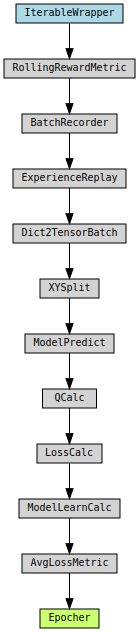

In [27]:

from torchdata.datapipes.utils import to_graph
to_graph(learn.train_pipe)

In [26]:
learn.fit(7)

taking step
taking step
taking step
taking step
taking step
taking step
taking step
taking step
taking step
taking step
taking step
taking step
taking step
taking step
taking step
taking step
taking step
taking step
taking step
taking step
taking step
taking step
taking step
taking step
taking step
taking step
taking step
taking step
taking step
taking step
taking step
taking step
taking step
taking step
taking step
taking step
taking step
taking step
taking step
taking step
taking step
taking step
taking step
taking step
taking step
taking step
taking step
taking step
taking step
taking step
found:  [AvgLossMetric, RollingRewardMetric]


/opt/conda/lib/python3.7/site-packages/gym/utils/passive_env_checker.py:98: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  "We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) "


loss,rolling_reward
None,nan
0.482128,nan
0.409861,nan
0.373620,nan
0.356339,nan
0.329100,nan
0.317722,nan


/opt/conda/lib/python3.7/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
# hide
from fastcore.imports import in_colab

# Since colab still requires tornado<6, we don't want to import nbdev if we don't have to
if not in_colab():
    from nbdev.export import *
    from nbdev.export2html import *
    from nbdev.cli import *
    make_readme()
    notebook2script(silent=True)